### Pre-requisites <a id=1></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install graphviz

In [3]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.0.2

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
  Using cached scikit_learn-1.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.5 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.9.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import seaborn as sns
import seaborn.objects as so

import warnings
warnings.filterwarnings("ignore")

# Scaling
from sklearn.preprocessing import RobustScaler

# Train Test Split
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve

# Adaboost
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import roc_auc_score

print('Packages imported...')

In [ ]:
!pip install tqdm

In [ ]:
!pip install ucimlrepo

In [ ]:
pip list

# <h1 align="center">Interpreting AdaBoost</h1>
### <h3 align="center">Identifying influential data instances using Deletion Diagnostics</h3>

### 1. Definitions <a id=1></a>
[back to top](#18)

In [ ]:
NUM_CLASSIFIERS = 30
ADABOOST_ALGO = 'SAMME.R'

### 2. Data <a id=6></a>

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/PhD/AdaBoost interpretability/dataset/heart.csv")
# from ucimlrepo import fetch_ucirepo

# # fetch dataset
# heart_disease = fetch_ucirepo(id=45)
# df = heart_disease.data.original

print("The shape of the dataset is : ", df.shape)

cat_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
con_cols = ["age","trtbps","chol","thalachh","oldpeak"]
target_col = ["output"]
print("The categorial cols are : ", cat_cols)
print("The continuous cols are : ", con_cols)
print("The target variable is :  ", target_col)

#### 2.1 Remove rows with missing values

In [ ]:
# print("Number of missing values for each feature:\n", df.isnull().sum())

df.dropna(inplace=True)
# print(df.isnull().sum())

print("Shape of the dataset (after removing missing values)): ", df.shape)

#### 2.2 Summary statistics

In [ ]:
dict = {}
for i in list(df.columns):
    dict[i] = df[i].value_counts().shape[0]

print("Unique values for each feaure:\n", pd.DataFrame(dict,index=["unique count"]).transpose())

# print("Stats for fcontinuous  df[con_cols].describe().transpose())

#### 2.3 Preprocessing <a id=11></a>
[back to top](#18)

##### 3.3.1 Scaling and Encoding features

In [ ]:
# creating a copy of df
df1 = df

# define the columns to be encoded and scaled
cat_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
con_cols = ["age","trtbps","chol","thalachh","oldpeak"]

# encoding the categorical columns
# df1 = pd.get_dummies(df1, columns = cat_cols, drop_first = True)

# defining the features and target
X = df1.drop(columns = 'output')

df1['output'] = df1['output'] * 2 - 1
y = df1[['output']]

# instantiating the scaler
scaler = RobustScaler()

# scaling the continuous featuree
# X[con_cols] = scaler.fit_transform(X[con_cols])
print("The first 5 rows of X are")
print(X.head())
print(y.head())

##### 3.3.2 Train and test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print("The shape of X_train is      ", X_train.shape)
print("The shape of X_test is       ",X_test.shape)
print("The shape of y_train is      ",y_train.shape)
print("The shape of y_test is       ",y_test.shape)

### 3. Base classifiers <a id=15></a>
[back to top](#18)

#### 3.1 Base - Adaboost classifier <a id=15></a>
[back to top](#18)

In [ ]:
ab_base = AdaBoostClassifier(n_estimators=NUM_CLASSIFIERS, algorithm=ADABOOST_ALGO)
ab_base.fit(X_train, y_train)
ab_score = ab_base.score(X_test, y_test)
print("Base AdaBoost classifier - score: ", ab_score)

y_pred = ab_base.predict(X_test)
y_decision_base = ab_base.decision_function(X_test)

accuracy_base = accuracy_score(y_test, y_pred)
print("Base AdaBoost classifier - Accuracy: ", accuracy_base)

roc_auc_base = round(roc_auc_score(y_test, y_pred), 4)
print('Base AdaBoost classifier - ROC-AUC score:', roc_auc_base)

# Loss function
total_loss_base = np.exp(ab_base.estimator_weights_).sum()
print('Base AdaBoost classifier - Total loss:', total_loss_base)


#### 3.2 Base - Logistic regression classifier<a id=15></a>
[back to top](#18)

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression().fit(X_train, y_train)
lr_score = lr.score(X_test, y_test)
print("Base LogisticRegression - score: ", lr_score)

lr_y_pred = lr.predict(X_test)

lr_accuracy_base = accuracy_score(y_test, lr_y_pred)
print("Base LogisticRegression - accuracy: ", lr_accuracy_base)

lr_roc_auc_base = round(roc_auc_score(y_test, lr_y_pred), 4)
print('Base LogisticRegression - ROC-AUC score:', lr_roc_auc_base)


#### 3.3 Base - GradientBoosting Classifier <a id=15></a>
[back to top](#18)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = AdaBoostClassifier(n_estimators=NUM_CLASSIFIERS).fit(X_train, y_train)
gb_score = gb.score(X_test, y_test)
print("Base GradientBoostingClassifier - score: ", gb_score)

gb_y_pred = gb.predict(X_test)

gb_accuracy_base = accuracy_score(y_test, gb_y_pred)
print("Base GradientBoostingClassifier - accuracy: ", gb_accuracy_base)

gb_roc_auc_base = round(roc_auc_score(y_test, gb_y_pred), 4)
print('Base GradientBoostingClassifier - ROC-AUC score:', gb_roc_auc_base)


#### 3.4 Base - Decision Tree Classifier <a id=15></a>
[back to top](#18)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier().fit(X_train, y_train)
dt_score = dt.score(X_test, y_test)
print("Base DecisionTreeClassifier - score: ", dt_score)

dt_y_pred = dt.predict(X_test)

dt_accuracy_base = accuracy_score(y_test, dt_y_pred)
print("Base DecisionTreeClassifier - accuracy: ", dt_accuracy_base)

dt_roc_auc_base = round(roc_auc_score(y_test, dt_y_pred), 4)
print('Base DecisionTreeClassifier - ROC-AUC score:', dt_roc_auc_base)

#### 3.5 Compare base classifiers <a id=15></a>
[back to top](#18)

In [ ]:
classifier_stats = [['AdaBoost', ab_score, roc_auc_base], ['Logistic Regression', lr_score, lr_roc_auc_base], ['Gradient Boosting', gb_score, gb_roc_auc_base], ['Decision Tree', dt_score, dt_roc_auc_base]]
df_stats = pd.DataFrame(classifier_stats, columns=['Classifier', 'Accuracy', 'ROC-AUC'])

df_stats



In [ ]:
plt.figure(figsize = (9, 4))

import seaborn as sns
bx = sns.barplot(x = 'Classifier', y = 'Accuracy', data = df_stats, width=0.5, hue='Classifier')
for i in bx.containers:
    bx.bar_label(i,)

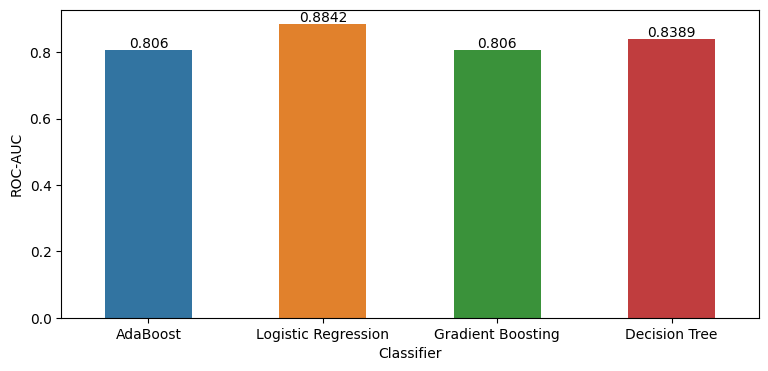

In [20]:
plt.figure(figsize = (9, 4))

import seaborn as sns
bx = sns.barplot(x = 'Classifier', y = 'ROC-AUC', data = df_stats, width=0.5, hue='Classifier')
for i in bx.containers:
    bx.bar_label(i,)

### 4. Adaboost - Deletion diagnostics <a id=15></a>
[back to top](#18)

#### 4.1 Deletion diagnostics by retraining the AdaBoost by removing each datapoint <a id=15></a>
[back to top](#18)

In [21]:
inf_d = [];
inf_f = [];
inf_data_t = [];

inf_features_importances = [];

from tqdm import tqdm

with tqdm(total=len(X_train.index)) as pbar:
  for di in X_train.index:
    pbar.update(1)
    ab_deldiag = AdaBoostClassifier(n_estimators=NUM_CLASSIFIERS, algorithm=ADABOOST_ALGO)
    ab_deldiag.fit(X_train.drop(index=di), y_train.drop(index=di))
    y_pred_deldiag = ab_deldiag.predict(X_test)
    y_decision_deldiag = ab_deldiag.decision_function(X_test)
    cooks_distance = (((y_decision_base - y_decision_deldiag)**2).sum()) / (ab_base.n_features_in_ * total_loss_base)

    accuracy_diff = accuracy_base - round(accuracy_score(y_test, y_pred_deldiag), 4)
    roc_auc_diff = roc_auc_base - round(roc_auc_score(y_test, y_pred_deldiag), 4)
    inf_d.append([accuracy_diff, roc_auc_diff, round(cooks_distance, 6)])
    inf_features_importances.append([accuracy_diff, roc_auc_diff, round(cooks_distance, 6)] + ab_deldiag.feature_importances_.tolist())

inf_d_df = pd.DataFrame(inf_d, columns=['Accuracy', 'AUC', 'CD'], index=X_train.index)
inf_d_df


100%|██████████| 242/242 [00:16<00:00, 15.06it/s]


,Accuracy,AUC,CD
132,-0.000021,0.0000,0.000038
202,0.016379,0.0172,0.000023
196,-0.016421,-0.0157,0.000001
75,-0.000021,0.0000,0.000000
176,-0.000021,0.0000,0.000001
...,...,...,...
188,0.016379,0.0172,0.000104
71,0.049179,0.0501,0.000081
106,-0.000021,0.0000,0.000015
270,0.049179,0.0485,0.000087


In [22]:
inf_d_df.describe()

,Accuracy,AUC,CD
count,242.000000,242.000000,242.000000
mean,0.010957,0.010995,0.000195
std,0.019061,0.018898,0.000946
min,-0.032821,-0.032900,0.000000
25%,-0.000021,0.000000,0.000001
50%,-0.000021,0.000000,0.000036
75%,0.032779,0.031200,0.000097
max,0.081979,0.082900,0.010481


#### 4.2 Identify the cut-off for Cook's distance for the datapoint to be influential using box plot <a id=15></a>
[back to top](#18)

In [23]:
from matplotlib.cbook import boxplot_stats
stats = boxplot_stats(inf_d_df['CD'].values)
stats

[{'mean': 0.00019502892561983472,
  'iqr': 9.6e-05,
  'cilo': 2.6311351449051223e-05,
  'cihi': 4.5688648550948765e-05,
  'whishi': 0.000219,
  'whislo': 0.0,
  'fliers': array([0.001583, 0.007995, 0.001204, 0.001406, 0.004349, 0.001411,
         0.001202, 0.00259 , 0.003868, 0.010481]),
  'q1': 1e-06,
  'med': 3.5999999999999994e-05,
  'q3': 9.7e-05}]

Text(0.000219, 0, '0.000219')

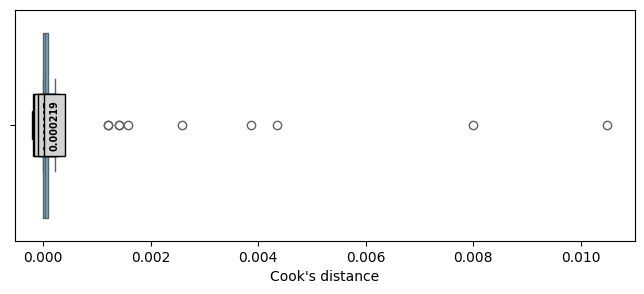

In [24]:
fig, ax = plt.subplots(figsize=(8, 3))

# ax.set_title('Box and whisker plot to show the\n distribution of the Cook\'s distances')
box_plot = sns.boxplot(data=inf_d_df['CD'], orient='h', palette="Blues", ax=ax)
box_plot.set(xlabel='Cook\'s distance')

box_plot.text(stats[0]['whislo'], 0, stats[0]['whislo'], ha='center', va='center', size='x-small', color='k',\
              weight='semibold' , rotation='vertical', bbox={'facecolor':'lightgray'})

box_plot.text(stats[0]['q1'], 0, '{:f}'.format(stats[0]['q1']), ha='center', va='center', size='x-small', color='k',\
              weight='semibold' , rotation='vertical', bbox={'facecolor':'lightgray'})

box_plot.text(stats[0]['med'], 0, '{:f}'.format(stats[0]['med']), ha='center', va='center', size='x-small', color='k',\
              weight='semibold' , rotation='vertical', bbox={'facecolor':'lightgray'})

box_plot.text(stats[0]['q3'], 0, '{:f}'.format(stats[0]['q3']), ha='center', va='center', size='x-small', color='k',\
              weight='semibold' , rotation='vertical', bbox={'facecolor':'lightgray'})

box_plot.text(stats[0]['whishi'], 0, '{:f}'.format(stats[0]['whishi']), ha='center', va='center', size='x-small', color='k',\
              weight='semibold' , rotation='vertical', bbox={'facecolor':'lightgray'})


In [25]:
influencial_df = inf_d_df[inf_d_df['CD'] >= stats[0]['whishi']]
influencial_df.rename(columns={'AUC': 'ROC-AUC', 'CD': 'Cook\'s distance'}).describe()

,Accuracy,ROC-AUC,Cook's distance
count,11.000000,11.000000,11.000000
mean,0.011906,0.011627,0.003301
std,0.023298,0.023188,0.003224
min,-0.032821,-0.032900,0.000219
25%,-0.000021,0.000000,0.001305
50%,-0.000021,0.001600,0.001583
75%,0.032779,0.031200,0.004108
max,0.049179,0.050100,0.010481


In [26]:
inf_feature_imp_df = pd.DataFrame(inf_features_importances, columns=['Accuracy', 'AUC', 'CD'] + ab_deldiag.feature_names_in_.tolist(), index=X_train.index)
inf_feature_imp_df[(inf_feature_imp_df['CD'] >= stats[0]['whishi']) & (inf_feature_imp_df['Accuracy'] > 0) & (inf_feature_imp_df['age'] > ab_base.feature_importances_[0])]

,Accuracy,AUC,CD,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
177,0.032779,0.0312,0.001583,0.233333,0.066667,0.033333,0.133333,0.100000,0.0,0.033333,0.100000,0.033333,0.100000,0.033333,0.1,0.033333
0,0.049179,0.0501,0.001411,0.200000,0.066667,0.033333,0.133333,0.100000,0.0,0.000000,0.066667,0.033333,0.166667,0.066667,0.1,0.033333
1,0.032779,0.0328,0.003868,0.233333,0.066667,0.033333,0.100000,0.133333,0.0,0.033333,0.033333,0.033333,0.166667,0.033333,0.1,0.033333


#### 4.3 Compare Cook's distance to the Accuracy and AUC-ROC achieved for the AdaBoost model by removing EACH datapoint <a id=15></a>
[back to top](#18)

In [27]:
df_temp = inf_d_df.sort_values('CD', ignore_index=True)
df_temp['Accuracy'] = (df_temp['Accuracy']/df_temp['Accuracy'].sum())
df_temp['CD'] = (df_temp['CD']/df_temp['CD'].sum())
print(df_temp)

     Accuracy     AUC        CD
0   -0.000008  0.0000  0.000000
1   -0.000008  0.0000  0.000000
2   -0.000008  0.0000  0.000000
3   -0.000008  0.0000  0.000000
4   -0.000008  0.0000  0.000000
..        ...     ...       ...
237  0.012362  0.0312  0.054876
238  0.012362  0.0328  0.081954
239 -0.000008  0.0000  0.092146
240 -0.012378 -0.0329  0.169396
241 -0.000008 -0.0017  0.222069

[242 rows x 3 columns]


In [28]:
inf_d_df[inf_d_df['CD'] >= 0.000172].sort_values('CD')

,Accuracy,AUC,CD
230,-0.000021,0.0016,0.000219
103,-0.000021,0.0000,0.001202
79,-0.000021,0.0000,0.001204
117,0.016379,0.0156,0.001406
0,0.049179,0.0501,0.001411
177,0.032779,0.0312,0.001583
110,0.032779,0.0312,0.002590
1,0.032779,0.0328,0.003868
136,-0.000021,0.0000,0.004349
158,-0.032821,-0.0329,0.007995


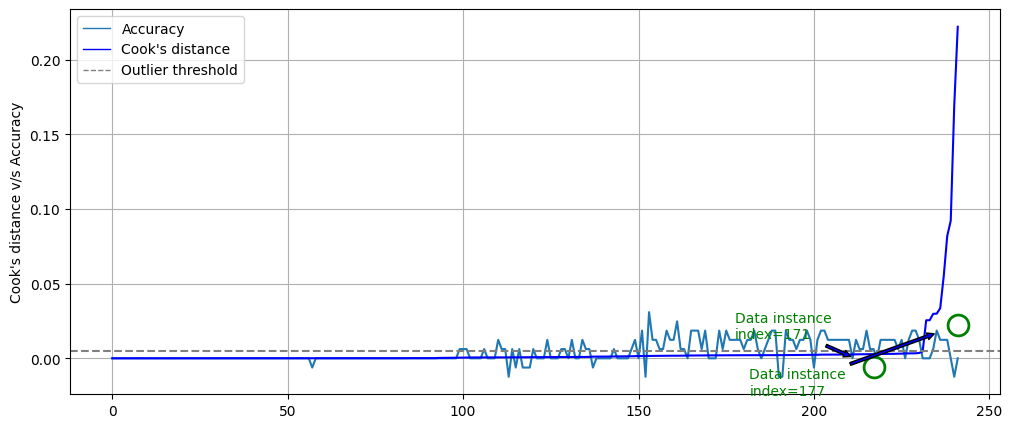

In [29]:
fig, ax = plt.subplots(figsize=[12, 5])
ax.set_ylabel('Cook\'s distance v/s Accuracy')

x1 = df_temp.index
y1 = df_temp['Accuracy']
plt.plot(x1, y1)

y1 = df_temp.sort_values('CD')['CD']
plt.plot(x1, y1, color='b')

stats_temp = boxplot_stats(df_temp['CD'].values)
limit = stats_temp[0]['whishi']
ax.axhline(limit, linestyle="--", color='grey')

point = (217, -0.005528)
radius = 15

ax.plot(point[0], point[1], 'o',
   ms=radius, mec='green', mfc='none', mew=2)

ax.annotate('Data instance\nindex=171', xy=point, xytext=(-100, 20),
   textcoords='offset points',
   color='green', size='medium',
   arrowprops={
      'arrowstyle':'simple', 'facecolor':'b', 'shrinkB': 15 * 1.2}
   )

point = (241, 0.022)
ax.plot(point[0], point[1], 'o',
   ms=radius, mec='green', mfc='none', mew=2)
ax.annotate('Data instance\nindex=177', xy=point, xytext=(-150, -50),
   textcoords='offset points',
   color='green', size='medium',
   arrowprops={
      'arrowstyle':'simple', 'facecolor':'b', 'shrinkB': 15 * 1.2}
   )

legend_elements = [Line2D([0], [0], lw=1, label='Accuracy'),
                   Line2D([0], [0], lw=1, color='b', label='Cook\'s distance'),
                   Line2D([0], [0], lw=1, color='grey', linestyle="--", label='Outlier threshold')]

ax.legend(handles=legend_elements)
plt.grid()
fig.show()

### 5. Adaboost - Influential data instances <a id=15></a>
[back to top](#18)

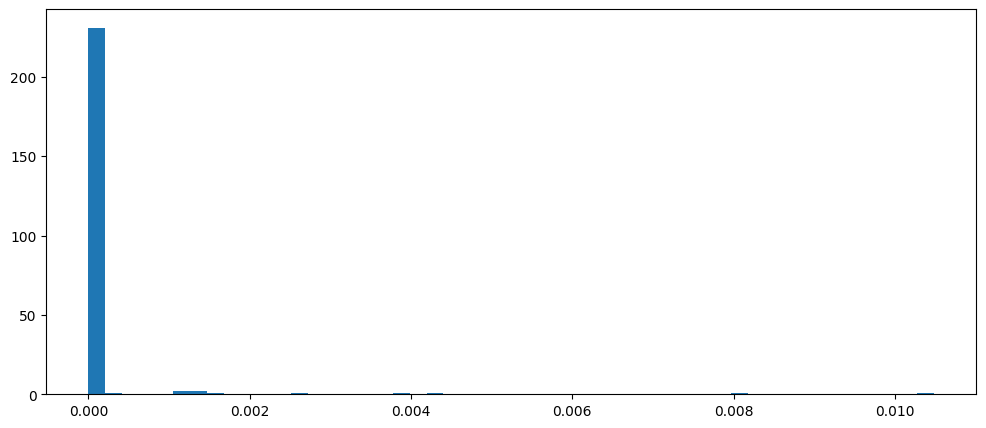

In [30]:
inf_d_df_sorted = inf_d_df.sort_values('CD')

# fig, ax = plt.subplots(2, 1, figsize=[10, 8])
# ax=ax.flatten()
fig, ax = plt.subplots(figsize=[12, 5])

label_map = {'CD': 'Cook\'s distance', 'AUC': 'ROC-AUC', 'Accuracy': 'Accuracy'}

x1 = range(0, len(inf_d_df_sorted['CD']))
y1 = inf_d_df_sorted['CD']
# ax.plot(x1, y1)
# ax.set_ylabel('Cook\'s distance')
# ax.axhline(stats[0]['whishi'], linestyle="--", color='g')
# ax.text(0, stats[0]['whishi'] + (stats[0]['whishi']/10), stats[0]['whishi'],
#            va="bottom", ha="left", bbox={'color':'c'})

plt.hist(y1, 50)

plt.show()



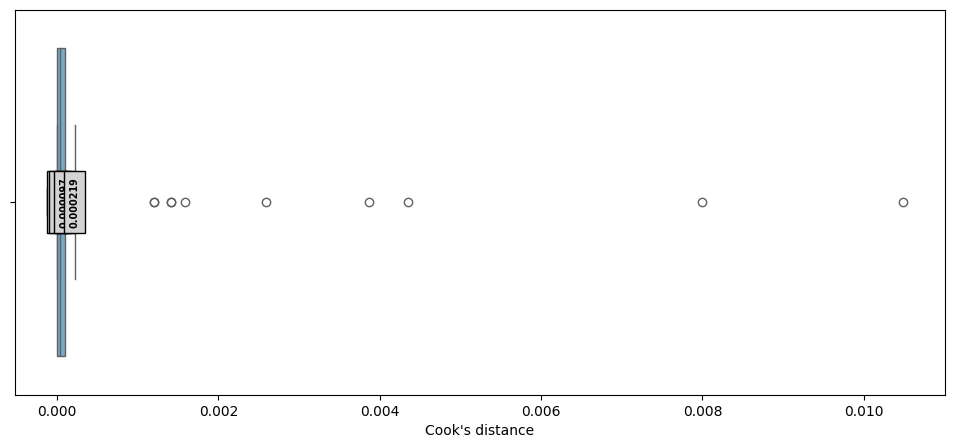

In [31]:
fig, ax = plt.subplots(figsize=[12, 5])
box_plot = sns.boxplot(data=inf_d_df['CD'], orient='h', palette="Blues", ax=ax)
box_plot.set(xlabel='Cook\'s distance')

box_plot.text(stats[0]['whislo'], 0, stats[0]['whislo'], ha='center', va='center', size='x-small', color='k',\
              weight='semibold' , rotation='vertical', bbox={'facecolor':'lightgray'})

box_plot.text(stats[0]['q1'], 0, '{:f}'.format(stats[0]['q1']), ha='center', va='center', size='x-small', color='k',\
              weight='semibold' , rotation='vertical', bbox={'facecolor':'lightgray'})

box_plot.text(stats[0]['med'], 0, '{:f}'.format(stats[0]['med']), ha='center', va='center', size='x-small', color='k',\
              weight='semibold' , rotation='vertical', bbox={'facecolor':'lightgray'})

box_plot.text(stats[0]['q3'], 0, '{:f}'.format(stats[0]['q3']), ha='center', va='center', size='x-small', color='k',\
              weight='semibold' , rotation='vertical', bbox={'facecolor':'lightgray'})

box_plot.text(stats[0]['whishi'], 0, '{:f}'.format(stats[0]['whishi']), ha='center', va='center', size='x-small', color='k',\
              weight='semibold' , rotation='vertical', bbox={'facecolor':'lightgray'})

plt.show()

In [32]:
inf_d_df_sorted.tail(20).merge(X_train, left_index=True, right_index=True).merge(y_train, left_index=True, right_index=True).sort_values('CD')

,Accuracy,AUC,CD,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
56,0.032779,0.0328,0.000141,48,1,0,122,222,0,0,186,0,0.0,2,0,2,1
22,0.032779,0.0328,0.000141,42,1,0,140,226,0,1,178,0,0.0,2,0,2,1
150,0.016379,0.0172,0.000146,66,1,0,160,228,0,0,138,0,2.3,2,0,1,1
259,0.032779,0.0344,0.000147,38,1,3,120,231,0,1,182,1,3.8,1,0,3,-1
171,-0.000021,0.0016,0.000154,48,1,1,110,229,0,1,168,0,1.0,0,0,3,-1
55,0.032779,0.0328,0.000155,52,1,1,134,201,0,1,158,0,0.8,2,1,2,1
222,0.049179,0.0485,0.000157,65,1,3,138,282,1,0,174,0,1.4,1,1,2,-1
252,0.049179,0.0485,0.000158,62,0,0,138,294,1,1,106,0,1.9,1,3,2,-1
34,0.032779,0.0328,0.000169,51,1,3,125,213,0,0,125,1,1.4,2,1,2,1
230,-0.000021,0.0016,0.000219,47,1,2,108,243,0,1,152,0,0.0,2,0,2,-1


In [33]:
x_177 = X_train.loc[X_train.index == 177]
y_pred_177 = ab_base.predict(x_177)
print(f"Predicted {y_pred_177}")
y_expected = y_train.loc[y_train.index == 177]
print(f"Expected {y_expected['output'].values}")

Predicted [-1]
Expected [-1]


In [34]:
%matplotlib inline

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def hat_graph(ax, xlabels, values, group_labels):
    def label_bars(heights, values, rects):
        """Attach a text label on top of each bar."""
        for height, value, rect in zip(heights, values, rects):
            # print(height, value, rect)
            # print(rect.get_x() + rect.get_width() / 2, height)
            xytext_offset = (0, 2)
            if (value == 0):
              xytext_offset = (-12, 2)
            elif (height == 0):
              xytext_offset = (0, 2)
            elif (rect.get_height() < 0):
              xytext_offset = (0, -14)
            # xytext_offset = (0, 2) if (rect.get_height() >= 0) else (0, -12)

            ax.annotate(r'$\blacktriangle $' + f' {value}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=xytext_offset,  # 4 points vertical offset.
                        textcoords='offset points',
                        ha='center', va='bottom')

    values = np.asarray(values)
    x = np.arange(values.shape[1])
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels)
    spacing = 0.1  # spacing between hat groups
    width = (1 - spacing) / values.shape[0]
    heights0 = values[0]
    for i, (heights, group_label) in enumerate(zip(values, group_labels)):
        style = {'fill': False} if i == 0 else {'edgecolor': 'black', 'color':'cyan'}
        rects = ax.bar(x - spacing/2 + i * width, heights - heights0,
                       width, bottom=heights0, label=group_label, **style)
    # print(values[1])
    # print(values[1]-values[0])
    label_bars((values[1]).round(1), (values[1]-values[0]).round(2), rects)

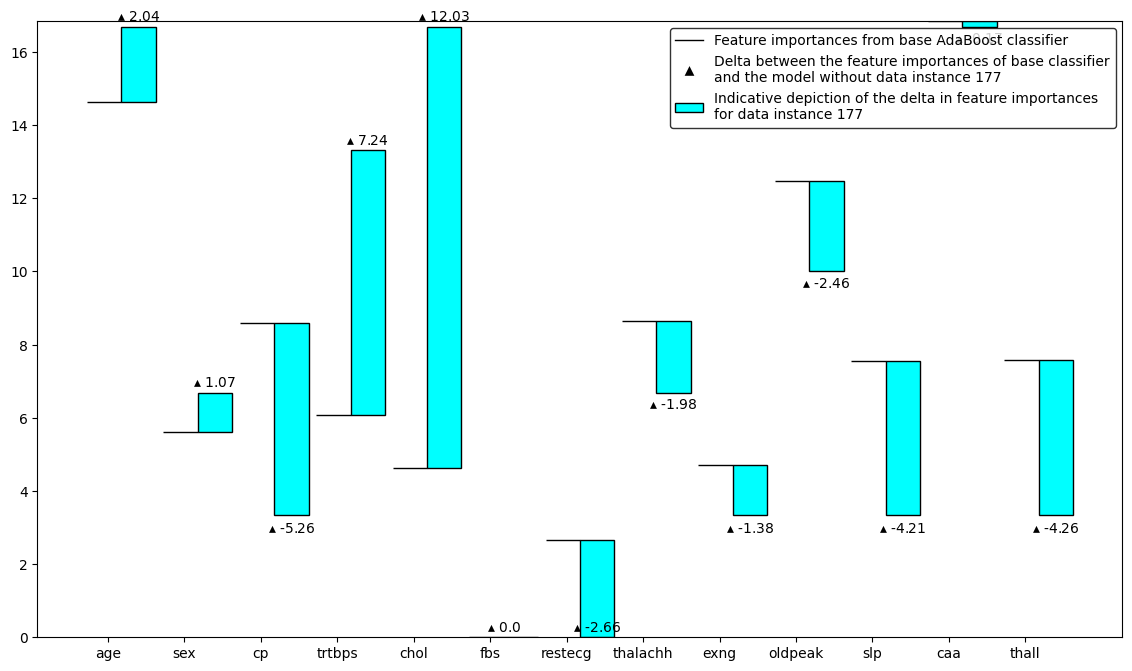

In [36]:
fig, ax = plt.subplots(figsize=[14, 8])

di_index = 177
# for i, di_index in enumerate(outliers_85th.tail(1).index):
ab_di = AdaBoostClassifier(n_estimators = 30, algorithm = 'SAMME')
ab_di.fit(X_train.drop(di_index), y_train.drop(di_index))

current_values = (ab_di.feature_importances_ * 100).round(2)
base_values = (ab_base.feature_importances_ * 100).round(2)
hat_graph(ax, ab_di.feature_names_in_, [current_values, base_values],
          ['Feature importances for\nbase AdaBoost classifier', f'Influence on feature importances\nfor data instance {di_index}'])

legend_elements = [Line2D([0], [0], color='black', lw=1, label='Feature importances from base AdaBoost classifier'),
                   Line2D([0], [0], marker='^', color='white', label=f'Delta between the feature importances of base classifier\nand the model without data instance {di_index}',
                          markerfacecolor='black', markersize=8),
                   Patch(facecolor='cyan', edgecolor='black',
                         label=f'Indicative depiction of the delta in feature importances\nfor data instance {di_index}')]

ax.legend(handles=legend_elements, edgecolor='black')
plt.show()

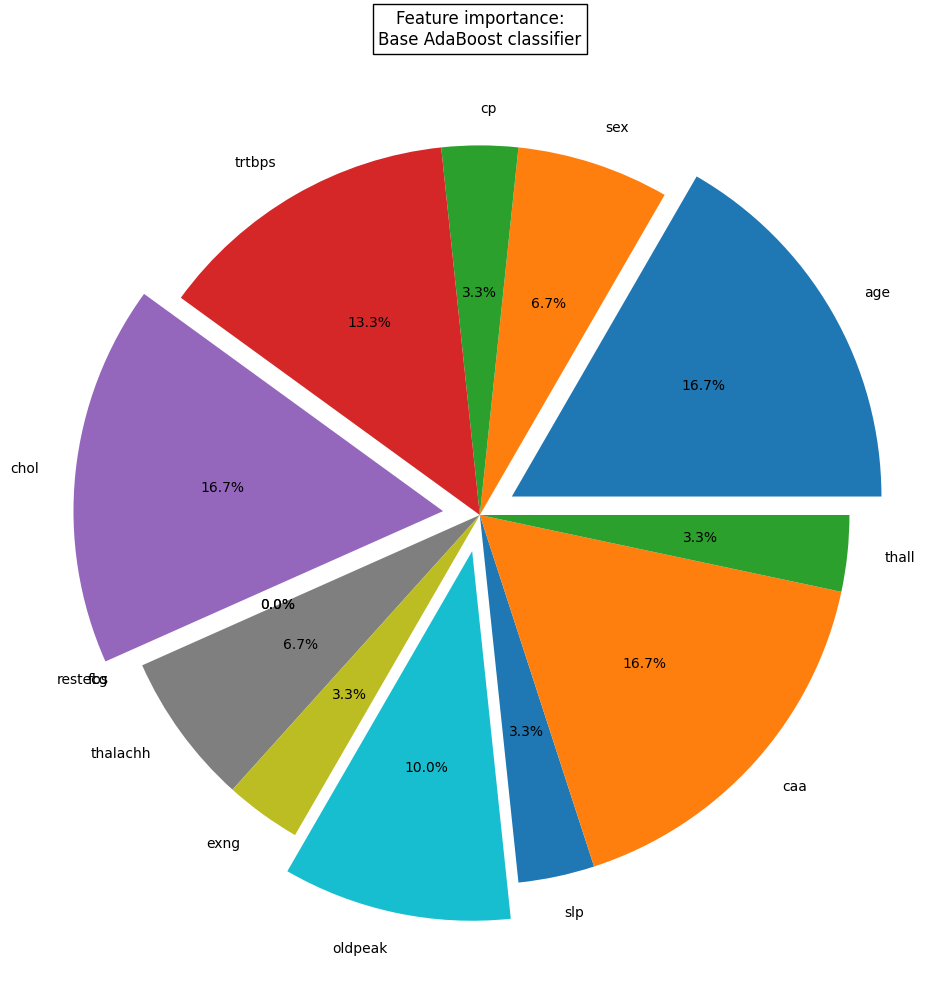

In [37]:
fig, ax = plt.subplots(figsize=[12, 12])

explode = (0.1, 0, 0, 0, 0.1, 0, 0, 0, 0, 0.1, 0, 0, 0)

ax.pie(ab_base.feature_importances_, labels=ab_base.feature_names_in_, autopct='%1.1f%%', explode=explode)
ax.set_title('Feature importance:\nBase AdaBoost classifier',
              bbox={'facecolor':'none', 'edgecolor':'black'})

plt.show()


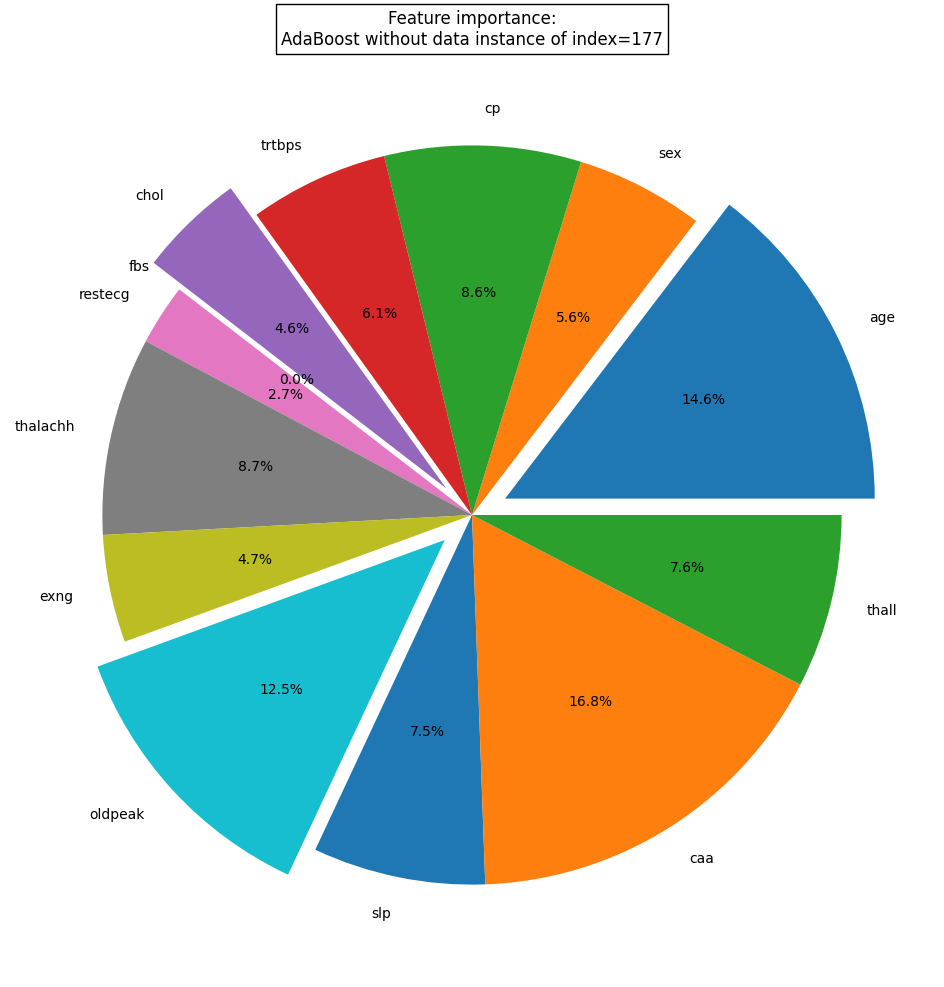

In [38]:
fig, ax = plt.subplots(figsize=[12, 12])

ax.pie(ab_di.feature_importances_, labels=ab_di.feature_names_in_, autopct='%1.1f%%', explode=explode)
ax.set_title('Feature importance:\nAdaBoost without data instance of index=177',
              bbox={'facecolor':'none', 'edgecolor':'black'})
plt.show()

In [39]:
classifiers = ab_di.estimators_
feature_names = ab_di.feature_names_in_
ensemble_clfs = []

for i, (clf) in enumerate(classifiers):
  clf_data_1 = []
  # clf_data_1.append(i+1)
  # clf_data_1.append(clf.tree_.feature[0])
  clf_data_1.append(feature_names[clf.tree_.feature[0]])
  clf_data_1.append(clf.tree_.threshold[0])
  clf_data_1.append(clf.tree_.impurity[0])
  ensemble_clfs.append(clf_data_1)

base_classifiers_df = pd.DataFrame(ensemble_clfs, columns=['feature', 'threshold', 'gini'])
base_classifiers_df.sort_index(level=0, axis=1)
base_classifiers_df.to_csv(f'/content/drive/MyDrive/PhD/AdaBoost interpretability/results/adaboost_{di_index}_features.csv')

In [40]:
import plotly.express as px
import plotly.graph_objects as go

categories = [ab_base.feature_names_in_]
# fig = plt.figure(constrained_layout=True, figsize=(12,12))
fig = go.Figure()
#product 1
fig.add_trace(go.Scatterpolar(
      r=ab_base.feature_importances_,
      theta=ab_base.feature_names_in_,
      fill='toself',
      name='Base AdaBoost',
      marker_symbol='star',  # Set the marker symbol (circle, square, diamond, etc.)
      marker_size=10,  # Set the marker size
      marker_color='green'  # Set the marker color
))

#product 1
fig.add_trace(go.Scatterpolar(
      r=ab_di.feature_importances_,
      theta=ab_di.feature_names_in_,
      fill='toself',
      name='AdaBoost without data instance 177',
      marker_symbol='square',  # Set the marker symbol (circle, square, diamond, etc.)
      marker_size=10,  # Set the marker size
      marker_color='red'  # Set the marker color
))


fig.update_layout(showlegend=True, font_color="#000")
fig.show()

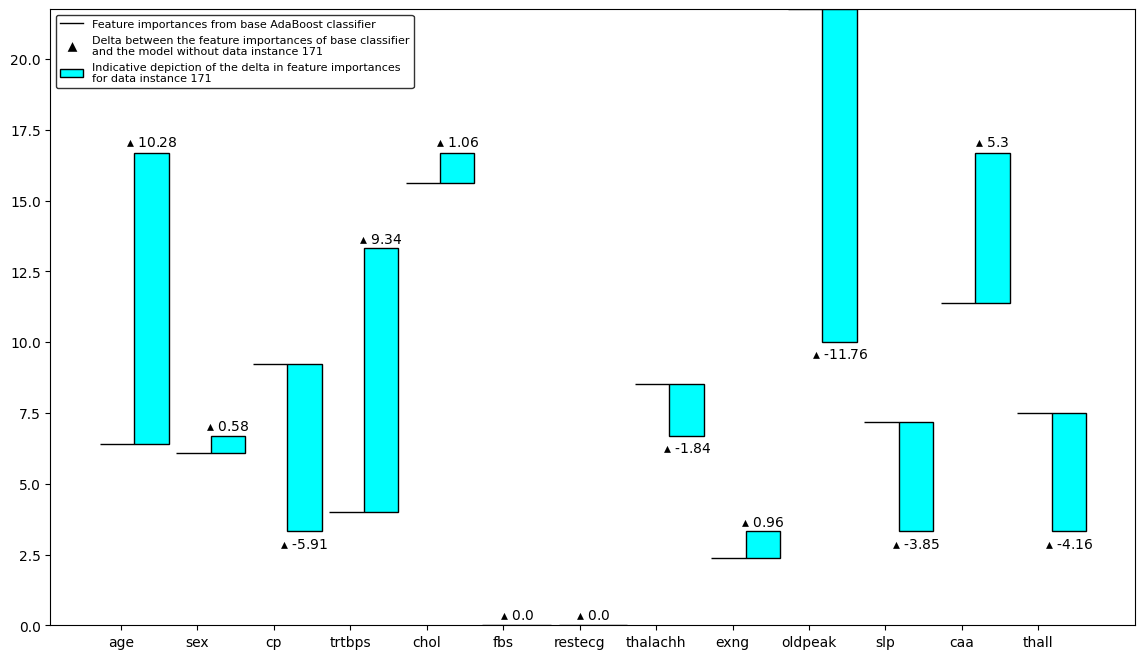

In [41]:
fig, ax = plt.subplots(figsize=[14, 8])

di_index = 171
ab_di = AdaBoostClassifier(n_estimators = 30, algorithm = 'SAMME')
ab_di.fit(X_train.drop(di_index), y_train.drop(di_index))

current_values = (ab_di.feature_importances_ * 100).round(2)
base_values = (ab_base.feature_importances_ * 100).round(2)
hat_graph(ax, ab_di.feature_names_in_, [current_values, base_values],
          ['Feature importances for\nbase AdaBoost classifier', f'Influence on feature importances\nfor data instance {di_index}'])

legend_elements = [Line2D([0], [0], color='black', lw=1, label='Feature importances from base AdaBoost classifier'),
                   Line2D([0], [0], marker='^', color='white', label=f'Delta between the feature importances of base classifier\nand the model without data instance {di_index}',
                          markerfacecolor='black', markersize=8),
                   Patch(facecolor='cyan', edgecolor='black',
                         label=f'Indicative depiction of the delta in feature importances\nfor data instance {di_index}')]

ax.legend(handles=legend_elements, edgecolor='black', fontsize=8)
plt.show()


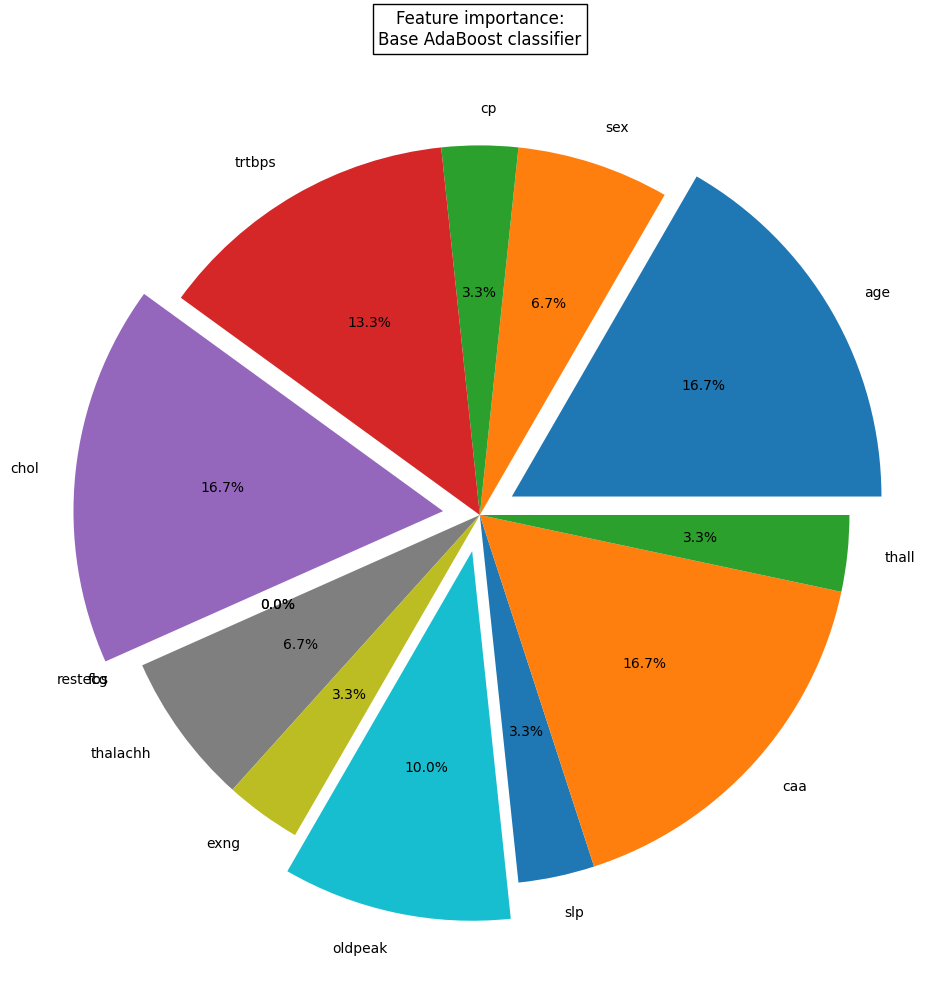

In [42]:
fig, ax = plt.subplots(figsize=[12, 12])

explode = (0.1, 0, 0, 0, 0.1, 0, 0, 0, 0, 0.1, 0, 0, 0)

ax.pie(ab_base.feature_importances_, labels=ab_base.feature_names_in_, autopct='%1.1f%%', explode=explode)
ax.set_title('Feature importance:\nBase AdaBoost classifier',
              bbox={'facecolor':'none', 'edgecolor':'black'})

plt.show()

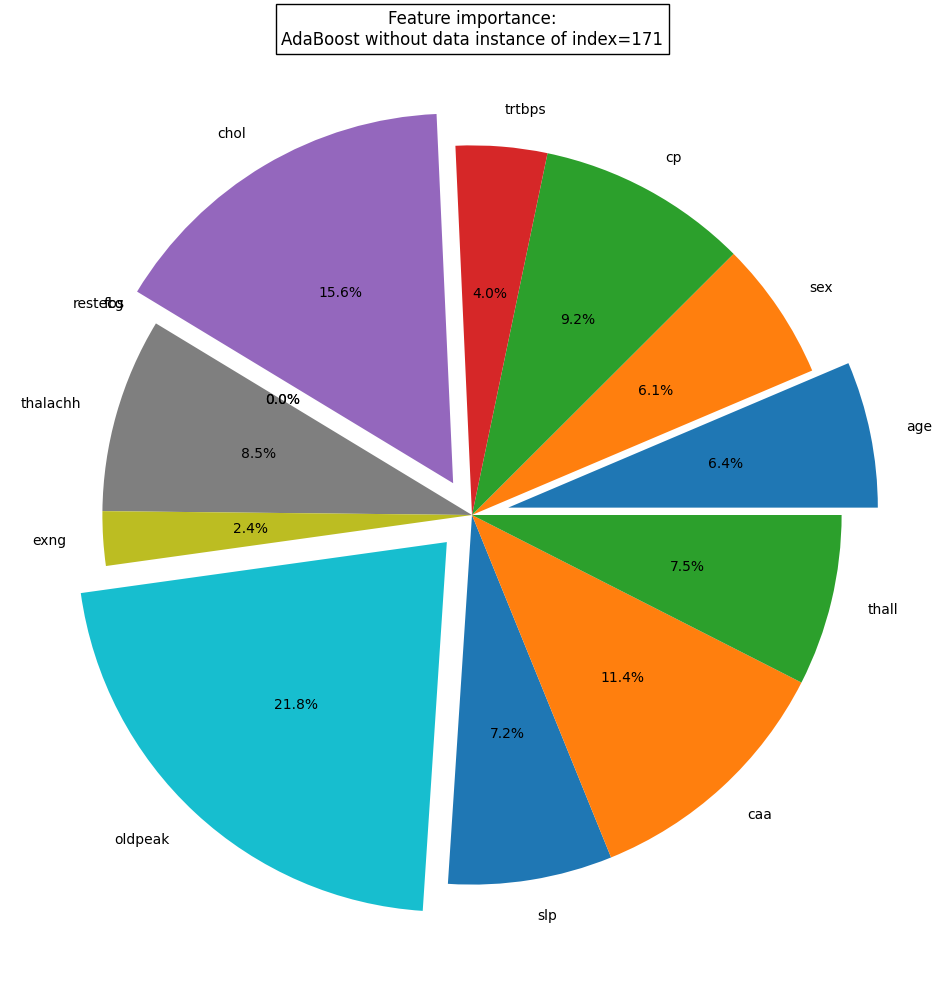

In [43]:
fig, ax = plt.subplots(figsize=[12, 12])

ax.pie(ab_di.feature_importances_, labels=ab_di.feature_names_in_, autopct='%1.1f%%', explode=explode)
ax.set_title(f'Feature importance:\nAdaBoost without data instance of index={di_index}',
              bbox={'facecolor':'none', 'edgecolor':'black'})



plt.show()

In [44]:
import plotly.express as px
import plotly.graph_objects as go

categories = [ab_base.feature_names_in_]
fig = go.Figure()
fig.add_trace(go.Scatterpolar(
      r=ab_base.feature_importances_,
      theta=ab_base.feature_names_in_,
      fill='toself',
      name='Base AdaBoost',
      marker_symbol='star',  # Set the marker symbol (circle, square, diamond, etc.)
      marker_size=10,  # Set the marker size
      marker_color='green'  # Set the marker color
))

fig.add_trace(go.Scatterpolar(
      r=ab_di.feature_importances_,
      theta=ab_di.feature_names_in_,
      fill='toself',
      name='AdaBoost without data instance 171',
      marker_symbol='square',  # Set the marker symbol (circle, square, diamond, etc.)
      marker_size=10,  # Set the marker size
      marker_color='red'  # Set the marker color
))


fig.update_layout(showlegend=True, font_color="#000")
fig.show()

#### Write output to CSV within Google drive <a id=15></a>
[back to top](#18)

In [45]:
classifiers = ab_di.estimators_
feature_names = ab_di.feature_names_in_
ensemble_clfs = []

for i, (clf) in enumerate(classifiers):
  clf_data_1 = []
  # clf_data_1.append(i+1)
  # clf_data_1.append(clf.tree_.feature[0])
  clf_data_1.append(feature_names[clf.tree_.feature[0]])
  clf_data_1.append(clf.tree_.threshold[0])
  clf_data_1.append(clf.tree_.impurity[0])
  ensemble_clfs.append(clf_data_1)

base_classifiers_df = pd.DataFrame(ensemble_clfs, columns=['feature', 'threshold', 'gini'])
base_classifiers_df.sort_index(level=0, axis=1)
base_classifiers_df.to_csv(f'/content/drive/MyDrive/PhD/AdaBoost interpretability/results/adaboost_{di_index}_features.csv')

In [46]:
classifiers = ab_base.estimators_
feature_names = ab_base.feature_names_in_
ensemble_clfs = []

for i, (clf) in enumerate(classifiers):
  clf_data_1 = []
  # clf_data_1.append(i+1)
  # clf_data_1.append(clf.tree_.feature[0])
  clf_data_1.append(feature_names[clf.tree_.feature[0]])
  clf_data_1.append(clf.tree_.threshold[0])
  clf_data_1.append(clf.tree_.impurity[0])
  ensemble_clfs.append(clf_data_1)

# print(ensemble_clfs)
# print("\n")

base_classifiers_df = pd.DataFrame(ensemble_clfs, columns=['feature', 'threshold', 'gini'])
# base_classifiers_df.columns = pd.MultiIndex.from_tuples(ensemble_clfs)
# base_classifiers_df.sort_index(axis=1, inplace=True)
# base_classifiers_df.reorder_levels([1,0], axis=1)
base_classifiers_df.sort_index(level=0, axis=1)
base_classifiers_df.to_csv('/content/drive/MyDrive/PhD/AdaBoost interpretability/results/adaboost_base_features.csv')

### 6. Adaboost - Without the `age` influenced data instances <a id=15></a>
[back to top](#18)

In [47]:
df_with_cd = inf_d_df_sorted.merge(X_train, left_index=True, right_index=True).merge(y_train, left_index=True, right_index=True);
df_with_cd

,Accuracy,AUC,CD,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
26,-0.000021,0.0000,0.000000,59,1,2,150,212,1,1,157,0,1.6,2,0,2,1
38,-0.000021,0.0000,0.000000,65,0,2,155,269,0,1,148,0,0.8,2,0,2,1
14,-0.000021,0.0000,0.000000,58,0,3,150,283,1,0,162,0,1.0,2,0,2,1
211,-0.000021,0.0000,0.000000,61,1,0,120,260,0,1,140,1,3.6,1,1,3,-1
234,-0.000021,0.0000,0.000000,70,1,0,130,322,0,0,109,0,2.4,1,3,2,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,0.032779,0.0312,0.002590,64,0,0,180,325,0,1,154,1,0.0,2,0,2,1
1,0.032779,0.0328,0.003868,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
136,-0.000021,0.0000,0.004349,60,0,2,120,178,1,1,96,0,0.0,2,0,2,1
158,-0.032821,-0.0329,0.007995,58,1,1,125,220,0,1,144,0,0.4,1,4,3,1


In [48]:
# rows_to_drop = inf_feature_imp_df[(inf_feature_imp_df['CD'] >= stats[0]['whishi']) & (inf_feature_imp_df['Accuracy'] <= 0) & (inf_feature_imp_df['age'] > ab_base.feature_importances_[0])].index.tolist()
# # rows_to_drop = inf_feature_imp_df[(inf_feature_imp_df['CD'] >= stats[0]['whishi']) & (inf_feature_imp_df['age'] < ab_base.feature_importances_[0])].index.tolist()
# rows_to_drop

In [49]:
# rows_to_drop = [278, 294, 20, 259]
rows_to_drop = [286, 230]

In [50]:
unbiased_training_df = df_with_cd.drop(index=rows_to_drop);
X_train_unbiased = unbiased_training_df.drop(columns = ['Accuracy', 'AUC', 'CD', 'output'])
X_train_unbiased.describe()


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,54.475000,0.654167,0.979167,130.437500,247.037500,0.129167,0.550000,150.058333,0.316667,1.018333,1.416667,0.679167,2.304167
std,9.225635,0.476633,1.016384,16.835291,52.942483,0.336085,0.531045,22.432156,0.466148,1.105141,0.607944,0.990110,0.595646
min,29.000000,0.000000,0.000000,94.000000,131.000000,0.000000,0.000000,88.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,212.000000,0.000000,0.000000,135.500000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,55.500000,1.000000,1.000000,130.000000,239.500000,0.000000,1.000000,154.000000,0.000000,0.800000,1.000000,0.000000,2.000000
75%,61.000000,1.000000,2.000000,140.000000,275.000000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000
max,77.000000,1.000000,3.000000,192.000000,564.000000,1.000000,2.000000,202.000000,1.000000,5.600000,2.000000,4.000000,3.000000


In [51]:
y_train_unbiased = unbiased_training_df[['output']]
y_train_unbiased.describe()

,output
count,240.000000
mean,0.108333
std,0.996192
min,-1.000000
25%,-1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [52]:
ab_unbiased = AdaBoostClassifier(n_estimators=NUM_CLASSIFIERS, algorithm=ADABOOST_ALGO)
ab_unbiased.fit(X_train_unbiased, y_train_unbiased)
ab_unbiased_score = ab_unbiased.score(X_test, y_test)
print("Unbiased AdaBoost classifier - score: ", ab_unbiased_score)

y_pred_unbiased = ab_unbiased.predict(X_test)
y_decision_unbiased = ab_unbiased.decision_function(X_test)

accuracy_unbiased = accuracy_score(y_test, y_pred_unbiased)
print("Unbiased AdaBoost classifier - Accuracy: ", accuracy_unbiased)

# roc_auc_base = round(roc_auc_score(y_test, y_pred), 4)
# print('Base AdaBoost classifier - ROC-AUC score:', roc_auc_base)

# # Loss function
# total_loss_base = np.exp(ab_base.estimator_weights_).sum()
# print('Base AdaBoost classifier - Total loss:', total_loss_base)

Unbiased AdaBoost classifier - score:  0.7868852459016393
Unbiased AdaBoost classifier - Accuracy:  0.7868852459016393


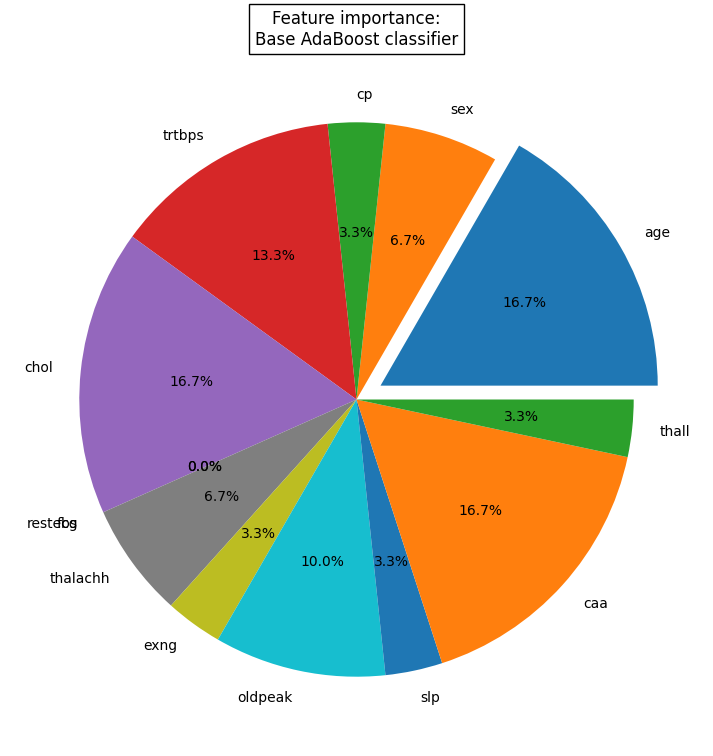

age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0.8032786885245902 , 0.16666666666666666,0.06666666666666667,0.03333333333333333,0.13333333333333333,0.16666666666666666,0.0,0.0,0.06666666666666667,0.03333333333333333,0.1,0.03333333333333333,0.16666666666666666,0.03333333333333333


In [53]:
fig, ax = plt.subplots(figsize=[9, 9])

explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

ax.pie(ab_base.feature_importances_, labels=ab_base.feature_names_in_, autopct='%1.1f%%', explode=explode)
ax.set_title(f'Feature importance:\nBase AdaBoost classifier',
              bbox={'facecolor':'none', 'edgecolor':'black'})
plt.show()

print(','.join(ab_base.feature_names_in_))
print(ab_base.score(X_test, y_test), ",", ','.join(map(str, ab_base.feature_importances_)))

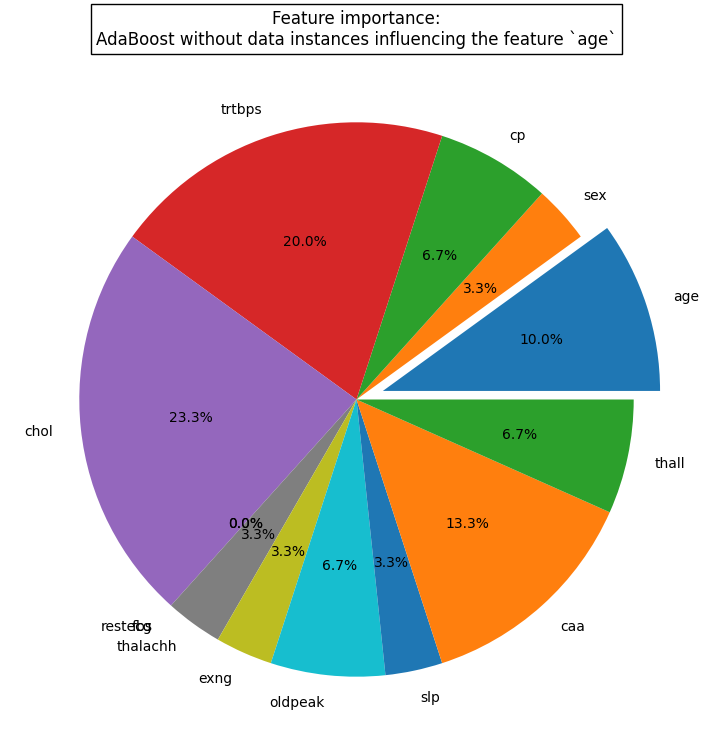

In [54]:
fig, ax = plt.subplots(figsize=[9, 9])
ax.pie(ab_unbiased.feature_importances_, labels=ab_unbiased.feature_names_in_, autopct='%1.1f%%', explode=explode)
ax.set_title(f'Feature importance:\nAdaBoost without data instances influencing the feature `age`',
              bbox={'facecolor':'none', 'edgecolor':'black'})
plt.show()

In [55]:
def feature_importance_chart(row_to_delete):
  X_train_del = X_train.drop(index=[row_to_delete])
  y_train_del = y_train.drop(index=[row_to_delete])

  print(f'Shape of dataset after deleting the instances {row_to_delete} X: {X_train_del.shape}, y: {y_train_del.shape}');

  ab_del = AdaBoostClassifier(n_estimators=NUM_CLASSIFIERS, algorithm=ADABOOST_ALGO)
  ab_del.fit(X_train_del, y_train_del)

  accuracy_del = ab_del.score(X_test, y_test)
  print(f'Accuracy after deleting rows: {row_to_delete} = {accuracy_del}' );
  print(f'Accuracy of base AdaBoost classifier = {ab_base.score(X_test, y_test)}' );


  explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

  fig, ax = plt.subplots(figsize=[9, 9])
  ax.pie(ab_del.feature_importances_, labels=ab_del.feature_names_in_, autopct='%1.1f%%', explode=explode)
  ax.set_title(f'Feature importance:\nAdaBoost without data instances {row_to_delete} influencing the feature `age`',
                bbox={'facecolor':'none', 'edgecolor':'black'})
  plt.show()

  print(f'Feature improtances after removing {row_to_delete}:')
  print(f'{row_to_delete},{accuracy_del},', ','.join(map(str, ab_del.feature_importances_)))

Shape of dataset after deleting the instances 182 X: (241, 13), y: (241, 1)
Accuracy after deleting rows: 182 = 0.8032786885245902
Accuracy of base AdaBoost classifier = 0.8032786885245902


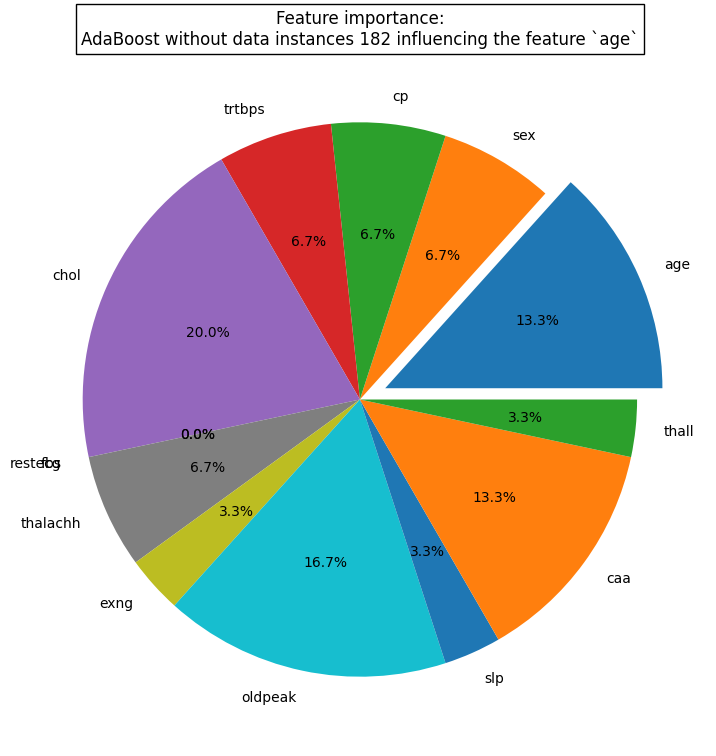

Feature improtances after removing 182:
182,0.8032786885245902, 0.13333333333333333,0.06666666666666667,0.06666666666666667,0.06666666666666667,0.2,0.0,0.0,0.06666666666666667,0.03333333333333333,0.16666666666666666,0.03333333333333333,0.13333333333333333,0.03333333333333333
Shape of dataset after deleting the instances 286 X: (241, 13), y: (241, 1)
Accuracy after deleting rows: 286 = 0.7868852459016393
Accuracy of base AdaBoost classifier = 0.8032786885245902


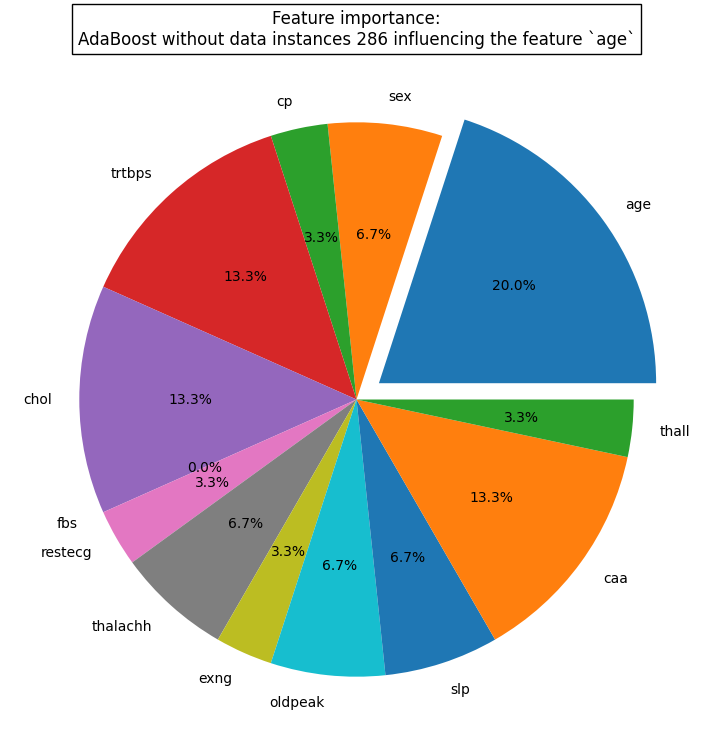

Feature improtances after removing 286:
286,0.7868852459016393, 0.2,0.06666666666666667,0.03333333333333333,0.13333333333333333,0.13333333333333333,0.0,0.03333333333333333,0.06666666666666667,0.03333333333333333,0.06666666666666667,0.06666666666666667,0.13333333333333333,0.03333333333333333
Shape of dataset after deleting the instances 278 X: (241, 13), y: (241, 1)
Accuracy after deleting rows: 278 = 0.8032786885245902
Accuracy of base AdaBoost classifier = 0.8032786885245902


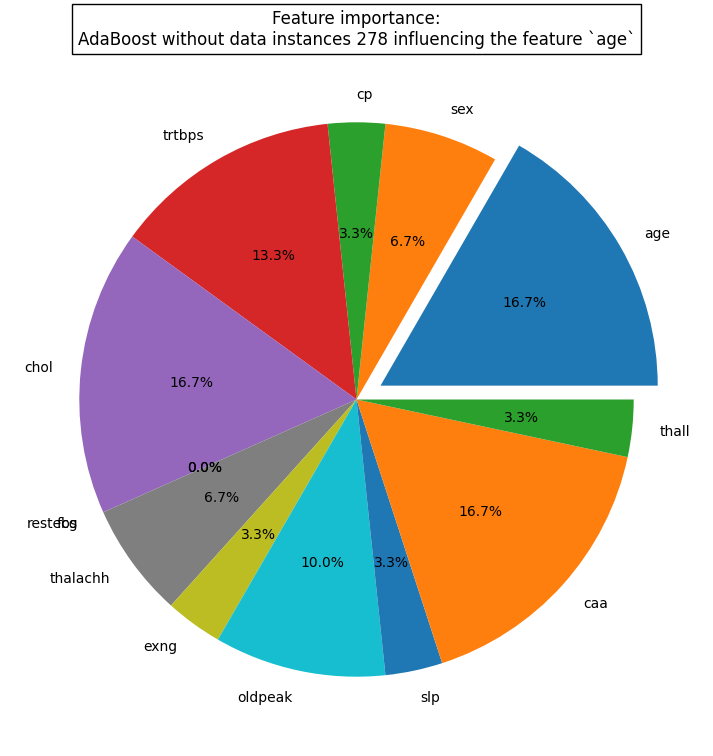

Feature improtances after removing 278:
278,0.8032786885245902, 0.16666666666666666,0.06666666666666667,0.03333333333333333,0.13333333333333333,0.16666666666666666,0.0,0.0,0.06666666666666667,0.03333333333333333,0.1,0.03333333333333333,0.16666666666666666,0.03333333333333333
Shape of dataset after deleting the instances 177 X: (241, 13), y: (241, 1)
Accuracy after deleting rows: 177 = 0.7704918032786885
Accuracy of base AdaBoost classifier = 0.8032786885245902


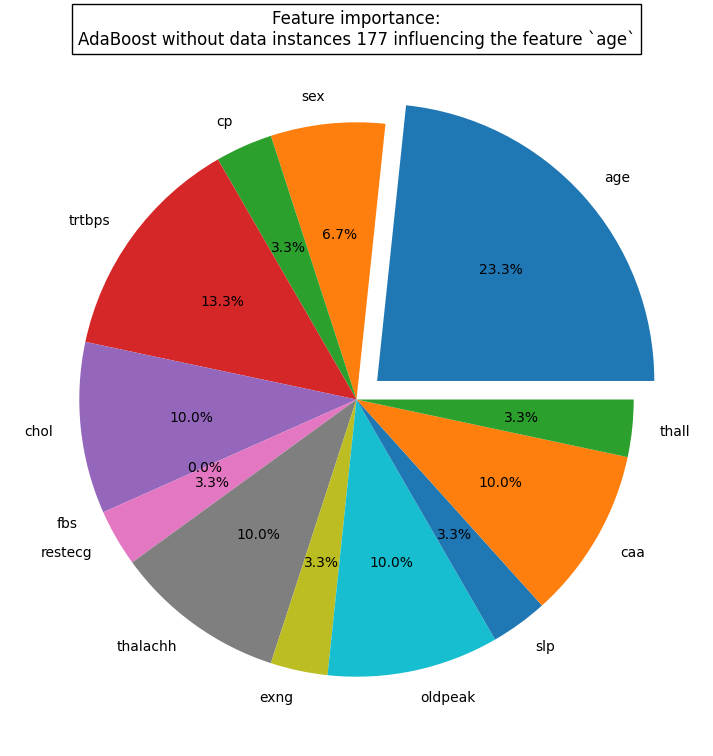

Feature improtances after removing 177:
177,0.7704918032786885, 0.23333333333333334,0.06666666666666667,0.03333333333333333,0.13333333333333333,0.1,0.0,0.03333333333333333,0.1,0.03333333333333333,0.1,0.03333333333333333,0.1,0.03333333333333333
Shape of dataset after deleting the instances 259 X: (241, 13), y: (241, 1)
Accuracy after deleting rows: 259 = 0.7704918032786885
Accuracy of base AdaBoost classifier = 0.8032786885245902


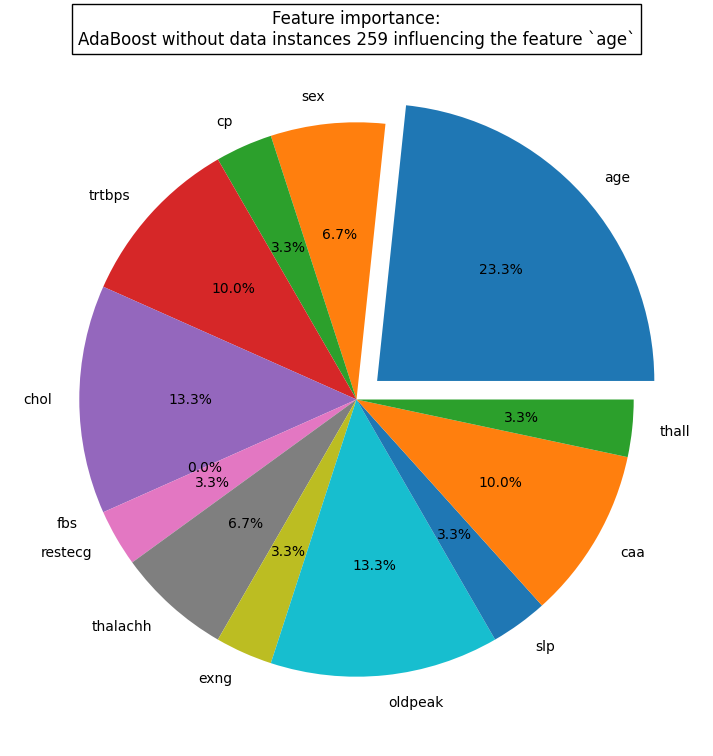

Feature improtances after removing 259:
259,0.7704918032786885, 0.23333333333333334,0.06666666666666667,0.03333333333333333,0.1,0.13333333333333333,0.0,0.03333333333333333,0.06666666666666667,0.03333333333333333,0.13333333333333333,0.03333333333333333,0.1,0.03333333333333333
Shape of dataset after deleting the instances 171 X: (241, 13), y: (241, 1)
Accuracy after deleting rows: 171 = 0.8032786885245902
Accuracy of base AdaBoost classifier = 0.8032786885245902


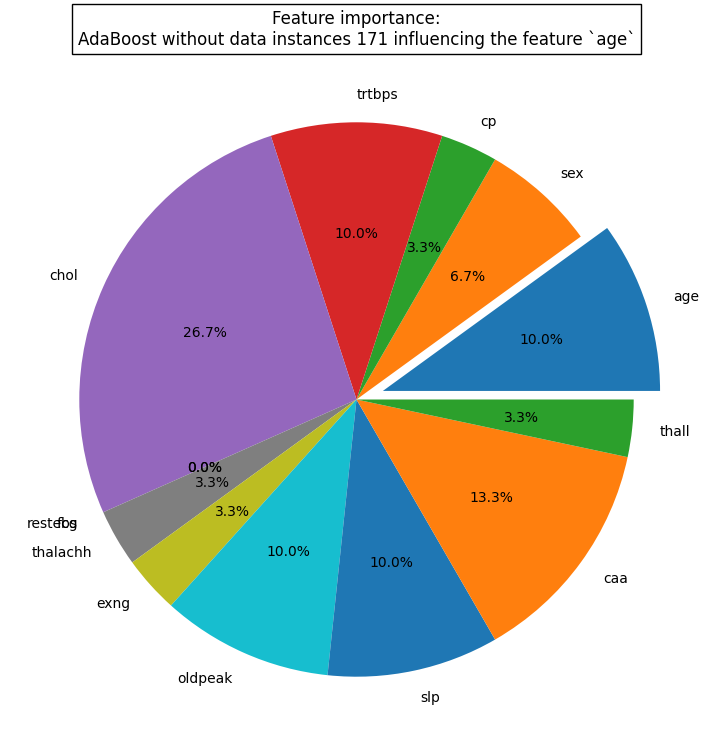

Feature improtances after removing 171:
171,0.8032786885245902, 0.1,0.06666666666666667,0.03333333333333333,0.1,0.26666666666666666,0.0,0.0,0.03333333333333333,0.03333333333333333,0.1,0.1,0.13333333333333333,0.03333333333333333


In [56]:
# Plot feature importances without each data instance influencing age
feature_importance_chart(182)
feature_importance_chart(286)
feature_importance_chart(278)
feature_importance_chart(177)
feature_importance_chart(259)
feature_importance_chart(171)

### 6. Adaboost - Plot features improtances of influential data points <a id=15></a>
[back to top](#18)

In [57]:
inf_feature_imp = inf_feature_imp_df[(inf_feature_imp_df['CD'] >= stats[0]['whishi'])]
inf_feature_imp

,Accuracy,AUC,CD,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
177,0.032779,0.0312,0.001583,0.233333,0.066667,0.033333,0.133333,0.100000,0.000000,0.033333,0.100000,0.033333,0.100000,0.033333,0.100000,0.033333
158,-0.032821,-0.0329,0.007995,0.166667,0.066667,0.033333,0.100000,0.200000,0.000000,0.000000,0.066667,0.033333,0.133333,0.033333,0.133333,0.033333
79,-0.000021,0.0000,0.001204,0.233333,0.066667,0.033333,0.133333,0.133333,0.000000,0.000000,0.066667,0.033333,0.100000,0.033333,0.133333,0.033333
230,-0.000021,0.0016,0.000219,0.100000,0.066667,0.066667,0.200000,0.166667,0.000000,0.000000,0.033333,0.033333,0.133333,0.033333,0.133333,0.033333
117,0.016379,0.0156,0.001406,0.166667,0.066667,0.033333,0.133333,0.133333,0.000000,0.000000,0.066667,0.033333,0.133333,0.033333,0.166667,0.033333
136,-0.000021,0.0000,0.004349,0.166667,0.066667,0.033333,0.133333,0.166667,0.000000,0.000000,0.066667,0.033333,0.100000,0.033333,0.166667,0.033333
0,0.049179,0.0501,0.001411,0.200000,0.066667,0.033333,0.133333,0.100000,0.000000,0.000000,0.066667,0.033333,0.166667,0.066667,0.100000,0.033333
103,-0.000021,0.0000,0.001202,0.233333,0.066667,0.033333,0.133333,0.133333,0.000000,0.000000,0.066667,0.033333,0.100000,0.033333,0.133333,0.033333
110,0.032779,0.0312,0.002590,0.166667,0.066667,0.033333,0.133333,0.166667,0.033333,0.000000,0.133333,0.033333,0.066667,0.033333,0.100000,0.033333
1,0.032779,0.0328,0.003868,0.233333,0.066667,0.033333,0.100000,0.133333,0.000000,0.033333,0.033333,0.033333,0.166667,0.033333,0.100000,0.033333


In [58]:
inf_feature_imp.describe()

,Accuracy,AUC,CD,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,0.011906,0.011627,0.003301,0.187879,0.066667,0.036364,0.127273,0.145455,0.003030,0.006061,0.075758,0.033333,0.121212,0.036364,0.127273,0.033333
std,0.023298,0.023188,0.003224,0.042876,0.000000,0.010050,0.032722,0.030814,0.010050,0.013484,0.033635,0.000000,0.030814,0.010050,0.025025,0.000000
min,-0.032821,-0.032900,0.000219,0.100000,0.066667,0.033333,0.066667,0.100000,0.000000,0.000000,0.033333,0.033333,0.066667,0.033333,0.100000,0.033333
25%,-0.000021,0.000000,0.001305,0.166667,0.066667,0.033333,0.116667,0.133333,0.000000,0.000000,0.066667,0.033333,0.100000,0.033333,0.100000,0.033333
50%,-0.000021,0.001600,0.001583,0.166667,0.066667,0.033333,0.133333,0.133333,0.000000,0.000000,0.066667,0.033333,0.133333,0.033333,0.133333,0.033333
75%,0.032779,0.031200,0.004108,0.233333,0.066667,0.033333,0.133333,0.166667,0.000000,0.000000,0.083333,0.033333,0.133333,0.033333,0.133333,0.033333
max,0.049179,0.050100,0.010481,0.233333,0.066667,0.066667,0.200000,0.200000,0.033333,0.033333,0.133333,0.033333,0.166667,0.066667,0.166667,0.033333


In [59]:
accuracy_base

0.8032786885245902

In [60]:
inf_feature_imp['Accuracy'] = (accuracy_base - inf_feature_imp_df['Accuracy']) * 100
inf_feature_imp

,Accuracy,AUC,CD,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
177,77.05,0.0312,0.001583,0.233333,0.066667,0.033333,0.133333,0.100000,0.000000,0.033333,0.100000,0.033333,0.100000,0.033333,0.100000,0.033333
158,83.61,-0.0329,0.007995,0.166667,0.066667,0.033333,0.100000,0.200000,0.000000,0.000000,0.066667,0.033333,0.133333,0.033333,0.133333,0.033333
79,80.33,0.0000,0.001204,0.233333,0.066667,0.033333,0.133333,0.133333,0.000000,0.000000,0.066667,0.033333,0.100000,0.033333,0.133333,0.033333
230,80.33,0.0016,0.000219,0.100000,0.066667,0.066667,0.200000,0.166667,0.000000,0.000000,0.033333,0.033333,0.133333,0.033333,0.133333,0.033333
117,78.69,0.0156,0.001406,0.166667,0.066667,0.033333,0.133333,0.133333,0.000000,0.000000,0.066667,0.033333,0.133333,0.033333,0.166667,0.033333
136,80.33,0.0000,0.004349,0.166667,0.066667,0.033333,0.133333,0.166667,0.000000,0.000000,0.066667,0.033333,0.100000,0.033333,0.166667,0.033333
0,75.41,0.0501,0.001411,0.200000,0.066667,0.033333,0.133333,0.100000,0.000000,0.000000,0.066667,0.033333,0.166667,0.066667,0.100000,0.033333
103,80.33,0.0000,0.001202,0.233333,0.066667,0.033333,0.133333,0.133333,0.000000,0.000000,0.066667,0.033333,0.100000,0.033333,0.133333,0.033333
110,77.05,0.0312,0.002590,0.166667,0.066667,0.033333,0.133333,0.166667,0.033333,0.000000,0.133333,0.033333,0.066667,0.033333,0.100000,0.033333
1,77.05,0.0328,0.003868,0.233333,0.066667,0.033333,0.100000,0.133333,0.000000,0.033333,0.033333,0.033333,0.166667,0.033333,0.100000,0.033333


<Axes: xlabel='age', ylabel='Accuracy'>

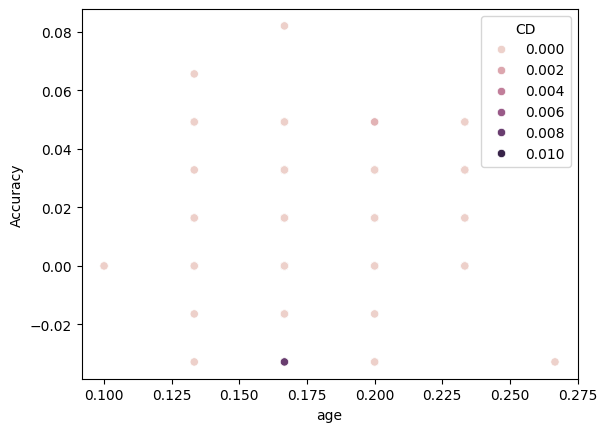

In [61]:
sns.scatterplot(data=inf_feature_imp_df[['Accuracy', 'age', 'cp']], x="age", y="Accuracy", hue=inf_feature_imp_df["CD"])
# sns.rugplot(data=inf_feature_imp_df[['Accuracy', 'age', 'cp']], x="age", y="Accuracy")

In [62]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

In [63]:
inf_feature_imp_df.index.to_frame()

,0
132,132
202,202
196,196
75,75
176,176
...,...
188,188
71,71
106,106
270,270


In [64]:
# inf_feature_imp_df[f'{feature}']

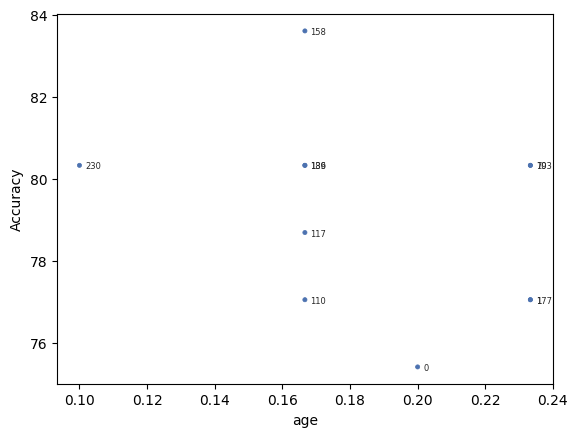

In [65]:
fig,ax = plt.subplots()
p = so.Plot(data=inf_feature_imp, x='age', y='Accuracy', text=inf_feature_imp.index).add(so.Dot(marker='.')).add(so.Text(halign='left', fontsize=6))
p.on(ax).show()

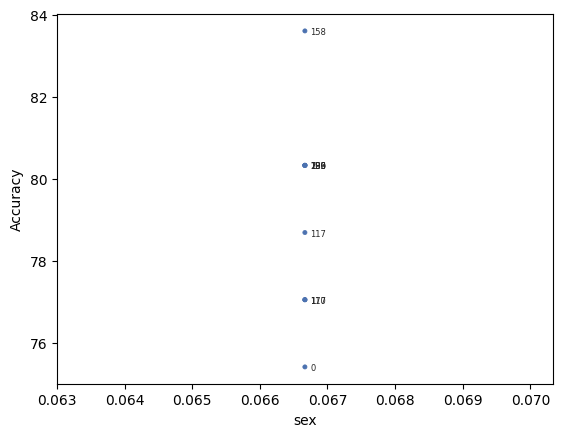

In [66]:
fig,ax = plt.subplots()
p = so.Plot(data=inf_feature_imp, x='sex', y='Accuracy', text=inf_feature_imp.index).add(so.Dot(marker='.')).add(so.Text(halign='left', fontsize=6))
p.on(ax).show()

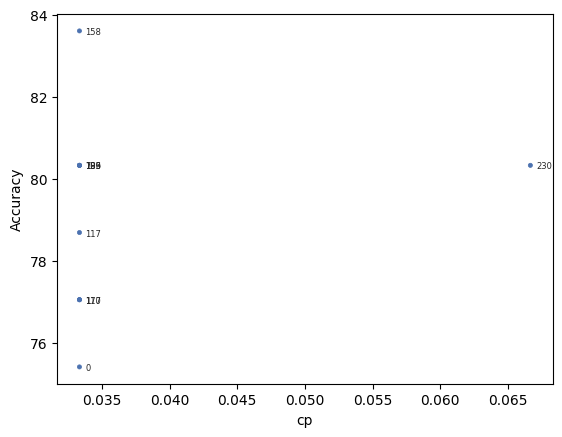

In [67]:
fig,ax = plt.subplots()
p = so.Plot(data=inf_feature_imp, x='cp', y='Accuracy', text=inf_feature_imp.index).add(so.Dot(marker='.')).add(so.Text(halign='left', fontsize=6))
p.on(ax).show()

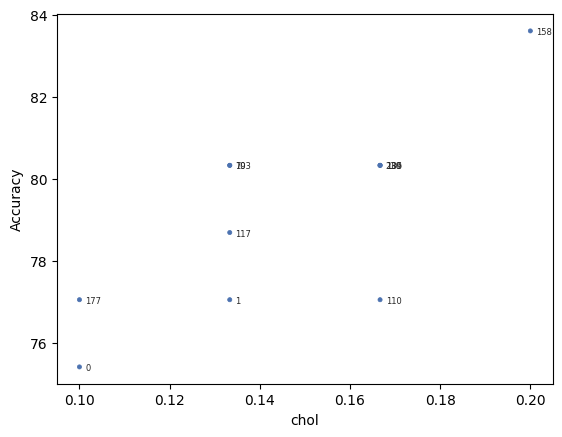

In [68]:
fig,ax = plt.subplots()
p = so.Plot(data=inf_feature_imp, x='chol', y='Accuracy', text=inf_feature_imp.index).add(so.Dot(marker='.')).add(so.Text(halign='left', fontsize=6))
p.on(ax).show()

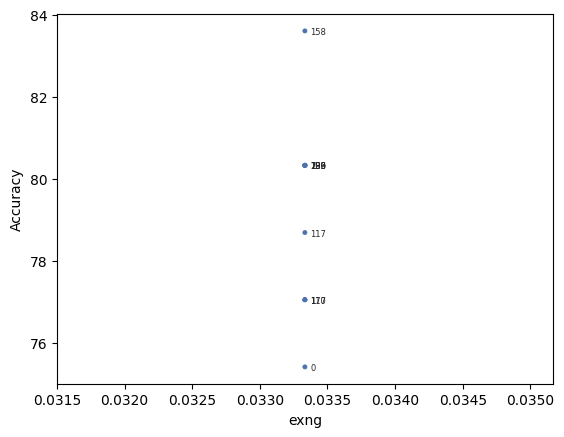

In [69]:
fig,ax = plt.subplots()
p = so.Plot(data=inf_feature_imp, x='exng', y='Accuracy', text=inf_feature_imp.index).add(so.Dot(marker='.')).add(so.Text(halign='left', fontsize=6))
p.on(ax).show()

### 6. Adaboost - with adapted feature importances<a id=15></a>
[back to top](#18)

Data indices negatively affecting accuracy:  [196, 52, 208, 94, 53, 200, 41, 159, 89, 43, 302, 158]
Size of training set (after removing the data instances reducing accuracy) X: 230 , y:  230
Accuracy score (after removing the data instances reducing accuracy):  0.8032786885245902


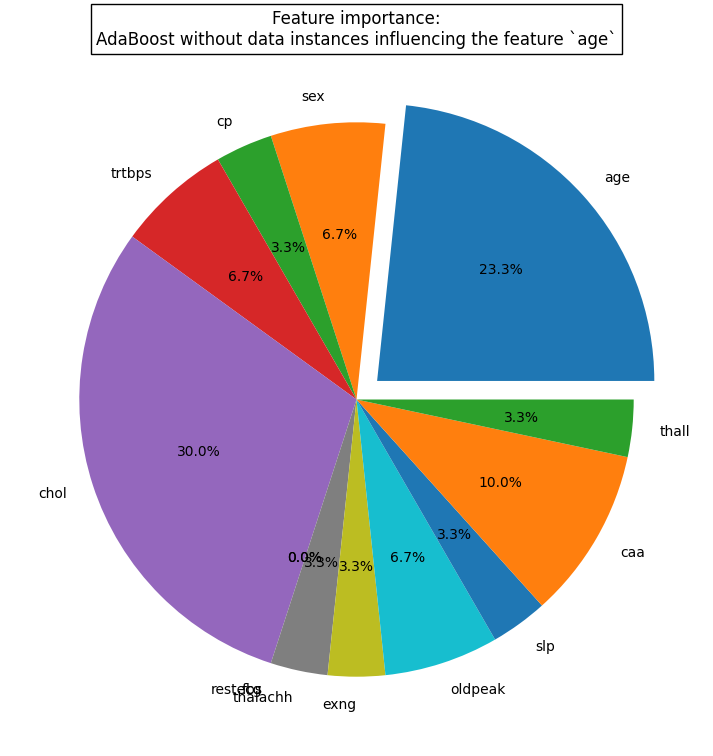

In [70]:
instances_affecting_accuracy = df_with_cd[round(df_with_cd['Accuracy'], 2) < 0].index.tolist()
print("Data indices negatively affecting accuracy: ", instances_affecting_accuracy)

X_train_imp = X_train.drop(index=instances_affecting_accuracy);
y_train_imp = y_train.drop(index=instances_affecting_accuracy)
print("Size of training set (after removing the data instances reducing accuracy) X:", X_train_imp.shape[0], ", y: ", y_train_imp.shape[0])

ab_imp = AdaBoostClassifier(n_estimators=NUM_CLASSIFIERS, algorithm=ADABOOST_ALGO)
ab_imp.fit(X_train_imp, y_train_imp)

print('Accuracy score (after removing the data instances reducing accuracy): ', ab_imp.score(X_test, y_test))

fig, ax = plt.subplots(figsize=[9, 9])
ax.pie(ab_imp.feature_importances_, labels=ab_imp.feature_names_in_, autopct='%1.1f%%', explode=explode)
ax.set_title(f'Feature importance:\nAdaBoost without data instances influencing the feature `age`',
              bbox={'facecolor':'none', 'edgecolor':'black'})
plt.show()

In [71]:
X_test_adapted = X_test[(X_test['age'] > 60)]
print("Data set after filtering on age:", X_test_adapted.shape)

indexes = X_test_adapted.index.tolist()

y_test_adapted = y_test.loc[indexes]
print("Result set after filtering on age:", y_test_adapted.shape)

# ab_adapted = AdaBoostClassifier(n_estimators=NUM_CLASSIFIERS, algorithm=ADABOOST_ALGO)
ab_score = ab_base.score(X_test_adapted, y_test_adapted)
print("Base AdaBoost classifier - score: ", ab_score)

ab_unbiased_score = ab_unbiased.score(X_test_adapted, y_test_adapted)
print("Adapted AdaBoost classifier - score: ", ab_unbiased_score)

ab_imp_score = ab_imp.score(X_test_adapted, y_test_adapted)
print("AdaBoost model (after improving accuracy) - score: ", ab_imp_score)

Data set after filtering on age: (14, 13)
Result set after filtering on age: (14, 1)
Base AdaBoost classifier - score:  0.9285714285714286
Adapted AdaBoost classifier - score:  0.7857142857142857
AdaBoost model (after improving accuracy) - score:  0.7857142857142857


In [72]:
X_test_adapted

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
60,71,0,2,110,265,1,0,130,0,0.0,2,1,2
279,61,1,0,138,166,0,0,125,1,3.6,1,1,2
152,64,1,3,170,227,0,0,155,0,0.6,1,0,3
272,67,1,0,120,237,0,1,71,0,1.0,1,0,2
25,71,0,1,160,302,0,1,162,0,0.4,2,2,2
139,64,1,0,128,263,0,1,105,1,0.2,1,1,3
284,61,1,0,140,207,0,0,138,1,1.9,2,1,3
198,62,1,0,120,267,0,1,99,1,1.8,1,2,3
17,66,0,3,150,226,0,1,114,0,2.6,0,0,2
168,63,1,0,130,254,0,0,147,0,1.4,1,1,3


In [73]:
y_test_adapted

,output
60,1
279,-1
152,1
272,-1
25,1
139,1
284,-1
198,-1
17,1
168,-1
